In [29]:
import pandas as pd
from pathlib import Path

df_f0 = pd.read_csv('outputs/biodiscover/05_preliminary_ept_run_efficientnet_b0/f0/predictions/biodiscover_none/_05_preliminary_ept_run_efficientnet_b0_f0_240531-1609-6044_epoch00_val-loss0.77_none.csv')
df_f1 = pd.read_csv('outputs/biodiscover/05_preliminary_ept_run_efficientnet_b0/f1/predictions/biodiscover_none/_05_preliminary_ept_run_efficientnet_b0_f1_240531-2115-976f_epoch00_val-loss0.62_none.csv')
df_f2 = pd.read_csv('outputs/biodiscover/05_preliminary_ept_run_efficientnet_b0/f2/predictions/biodiscover_none/_05_preliminary_ept_run_efficientnet_b0_f2_240601-0259-07e8_epoch00_val-loss1.05_none.csv')
df_f3 = pd.read_csv('outputs/biodiscover/05_preliminary_ept_run_efficientnet_b0/f3/predictions/biodiscover_none/_05_preliminary_ept_run_efficientnet_b0_f3_240601-0753-f98c_epoch00_val-loss0.79_none.csv')
df_f4 = pd.read_csv('outputs/biodiscover/05_preliminary_ept_run_efficientnet_b0/f4/predictions/biodiscover_none/_05_preliminary_ept_run_efficientnet_b0_f4_240601-1251-111a_epoch00_val-loss0.78_none.csv')
ref = pd.read_csv('data/processed/ept/01_EPT_processed_5splits_Final_species_label.csv')

df = pd.concat([df_f0, df_f1, df_f2, df_f3, df_f4])

# Get just the filename from the full path
df["fname"] = df["fname"].apply(lambda x: Path(x).name)
preds = df[["fname", "y_pred"]].set_index("fname")

# Join the dataframes. 'inner' to keep only the rows that are in both dataframes
results_df = ref.join(preds, how="inner", on="Image File Name")  

# Choose wanted columns
results_df = results_df[["Final_species_label", "y_pred", "individual"]]

# Grouped by individual
results_df_grouped = results_df.groupby(["individual"]).agg(lambda x: pd.Series.mode(x)[0])
results_df

,Final_species_label,y_pred,individual
3008,Baetis rhodani,Baetis vernus,4_H11
3008,Baetis rhodani,Baetis rhodani,4_H11
3008,Baetis rhodani,Baetis rhodani,4_H11
3008,Baetis rhodani,Baetis rhodani,4_H11
3008,Baetis rhodani,Baetis rhodani,4_H11
...,...,...,...
143278,Baetis rhodani,Baetis rhodani,10_C10
143278,Baetis rhodani,Baetis rhodani,10_C10
143278,Baetis rhodani,Baetis rhodani,10_C10
143278,Baetis rhodani,Baetis rhodani,10_C10


In [30]:
results_df_grouped

,Final_species_label,y_pred
individual,,
10_A10,Athripsodes cinereus,Athripsodes cinereus
10_A7,Limnephilus lunatus,Limnephilus lunatus
10_A8,Goera pilosa,Goera pilosa
10_A9,Athripsodes cinereus,Athripsodes cinereus
10_B3,Goera pilosa,Goera pilosa
...,...,...
9_E2,Athripsodes cinereus,Athripsodes cinereus
9_F10,Limnephilus lunatus,Limnephilus lunatus
9_F9,Limnephilus lunatus,Limnephilus lunatus


In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
def confusion_matrixX(y_true, 
                      y_pred, 
                      classes, 
                      figsize=(15,15), 
                      fonts=(18,10,18), 
                      rotate=False,
                      grid=False,
                      normalize='true'):

    # Check the inputs
    s_true = set(np.unique(y_true))
    s_pred = set(np.unique(y_pred))

    if classes == 'union':
        classes = sorted(list(s_true | s_pred))

    if len((s_true | s_pred) - set(classes)) > 0:
        warnings.warn(f"The inputs contain classes not present in the class list: {(s_true | s_pred) - set(classes)}")

    cm = confusion_matrix(y_true, 
                          y_pred, 
                          labels=classes,
                          normalize=normalize)
    
    if normalize:
        cm = cm*100
    fig, ax = plt.subplots(figsize=figsize)

    mask = np.zeros_like(cm)
    mask[cm==0] = 1
    sns.heatmap(cm, 
                annot=True, 
                annot_kws={"size": fonts[0]},
                fmt='.0f', 
                cmap="YlGnBu",
                xticklabels=classes, 
                yticklabels=classes,
                mask=mask,
                square=True, 
                cbar=False,
                ax=ax)
    
    if grid:
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')

    ax.set_ylabel('True label', size=fonts[2])
    ax.set_xlabel('Predicted label', size=fonts[2])
    ax.yaxis.set_ticks_position('none') 
    ax.xaxis.set_ticks_position('none') 
    
    if rotate:
        if isinstance(rotate, list):
            rot_x = rotate[0]
            rot_y = rotate[1]
        else:
            rot_x = rot_y = rotate
        plt.setp(ax.get_yticklabels(), rotation=rot_x, ha="right", rotation_mode="anchor", size=fonts[1])
        plt.setp(ax.get_xticklabels(), rotation=rot_y, ha="right", rotation_mode="anchor", size=fonts[1])
    else:
        plt.setp(ax.get_yticklabels(), size=fonts[1])
        plt.setp(ax.get_xticklabels(), size=fonts[1])
        
    plt.show()

from sklearn.metrics import classification_report
def classification_reportX(*args, 
                           figsize=None, 
                           fonts=(12,10,10),
                           rotate=True, 
                           bbox_anchor=(1.15,0.8), 
                           **kwargs):
    """Extends classification report by adding an useful plot for the performance across classes"""
    r = classification_report(*args, **kwargs, output_dict=True)
    rdf0 = pd.DataFrame(r)
    rdf = rdf0.T.iloc[:-3,:].sort_values('support',ascending=False)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    xbar = range(len(rdf))
    ax1.bar(xbar,rdf['support'], alpha=0.2)
    ax2.plot(rdf['f1-score'], 'ro', label='f1-score')
    ax2.plot(rdf['precision'], 'g*', label='precision', alpha=0.5)
    ax2.plot(rdf['recall'], 'b*', label='recall', alpha=0.5)

    ax2.vlines(xbar, rdf['f1-score'], rdf['precision'], 'g')
    ax2.vlines(xbar, rdf['f1-score'], rdf['recall'], 'b')

    ax2.hlines(rdf0['weighted avg']['f1-score'], 0,len(rdf), color='r', linestyle='--', label='weighted f1-score')
    ax2.hlines(rdf0['macro avg']['f1-score'], 0,len(rdf), color='r', linestyle='-.', label='macro f1-score')
    ax2.hlines(rdf0['accuracy']['recall'], 0,len(rdf), color='b', linestyle='--', label='accuracy')
    
    if rotate:
        plt.setp(ax1.get_xticklabels(), 
                 rotation=45, 
                 ha="right", 
                 rotation_mode="anchor",
                 size=fonts[1])

    fig.legend(bbox_to_anchor=bbox_anchor,
               prop={"size": fonts[2]})
    
    ax2.set_ylabel("Score", size=fonts[0])
    ax1.set_ylabel("Support", size=fonts[0])
    plt.setp(ax1.get_yticklabels(),
             size=fonts[0])
    plt.setp(ax2.get_yticklabels(),
             size=fonts[0])
    
    return classification_report(*args, **kwargs)

                            precision    recall  f1-score   support

    Amphinemura standfussi       1.00      1.00      1.00         1
          Anabolia nervosa       1.00      1.00      1.00         1
      Athripsodes cinereus       1.00      1.00      1.00         7
            Baetis rhodani       0.90      1.00      0.95         9
             Baetis vernus       1.00      0.50      0.67         2
            Caenis horaria       1.00      1.00      1.00         4
      Chaetopteryx villosa       1.00      0.78      0.88         9
           Ephemera danica       1.00      1.00      1.00        13
              Goera pilosa       0.96      1.00      0.98        27
          Halesus radiatus       1.00      0.67      0.80         3
       Limnephilus lunatus       0.96      1.00      0.98        49
        Mystacides azureus       1.00      1.00      1.00         2
           Nemoura cinerea       1.00      1.00      1.00         2
Potamophylax rotundipennis       1.00      1.00

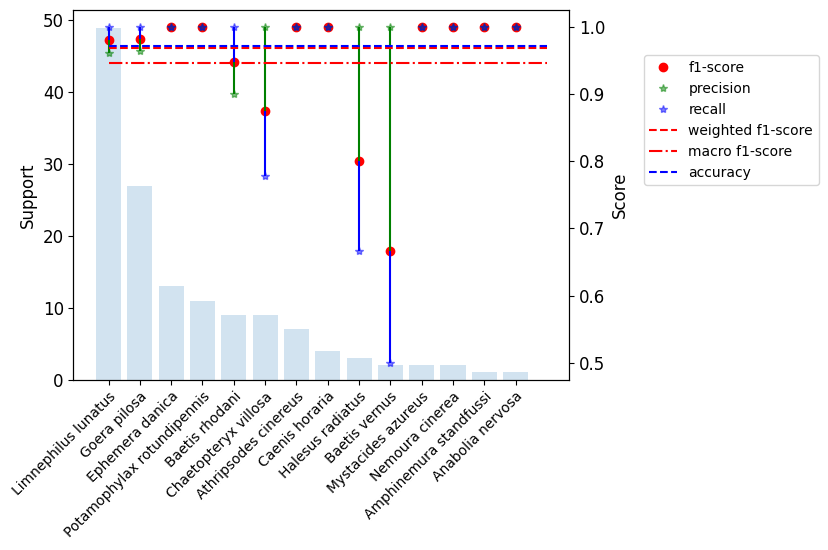

In [32]:
print(classification_reportX(results_df_grouped["Final_species_label"],
                             results_df_grouped["y_pred"],
                             zero_division=0,
                             bbox_anchor=(1.3,0.8)))
plt.show()

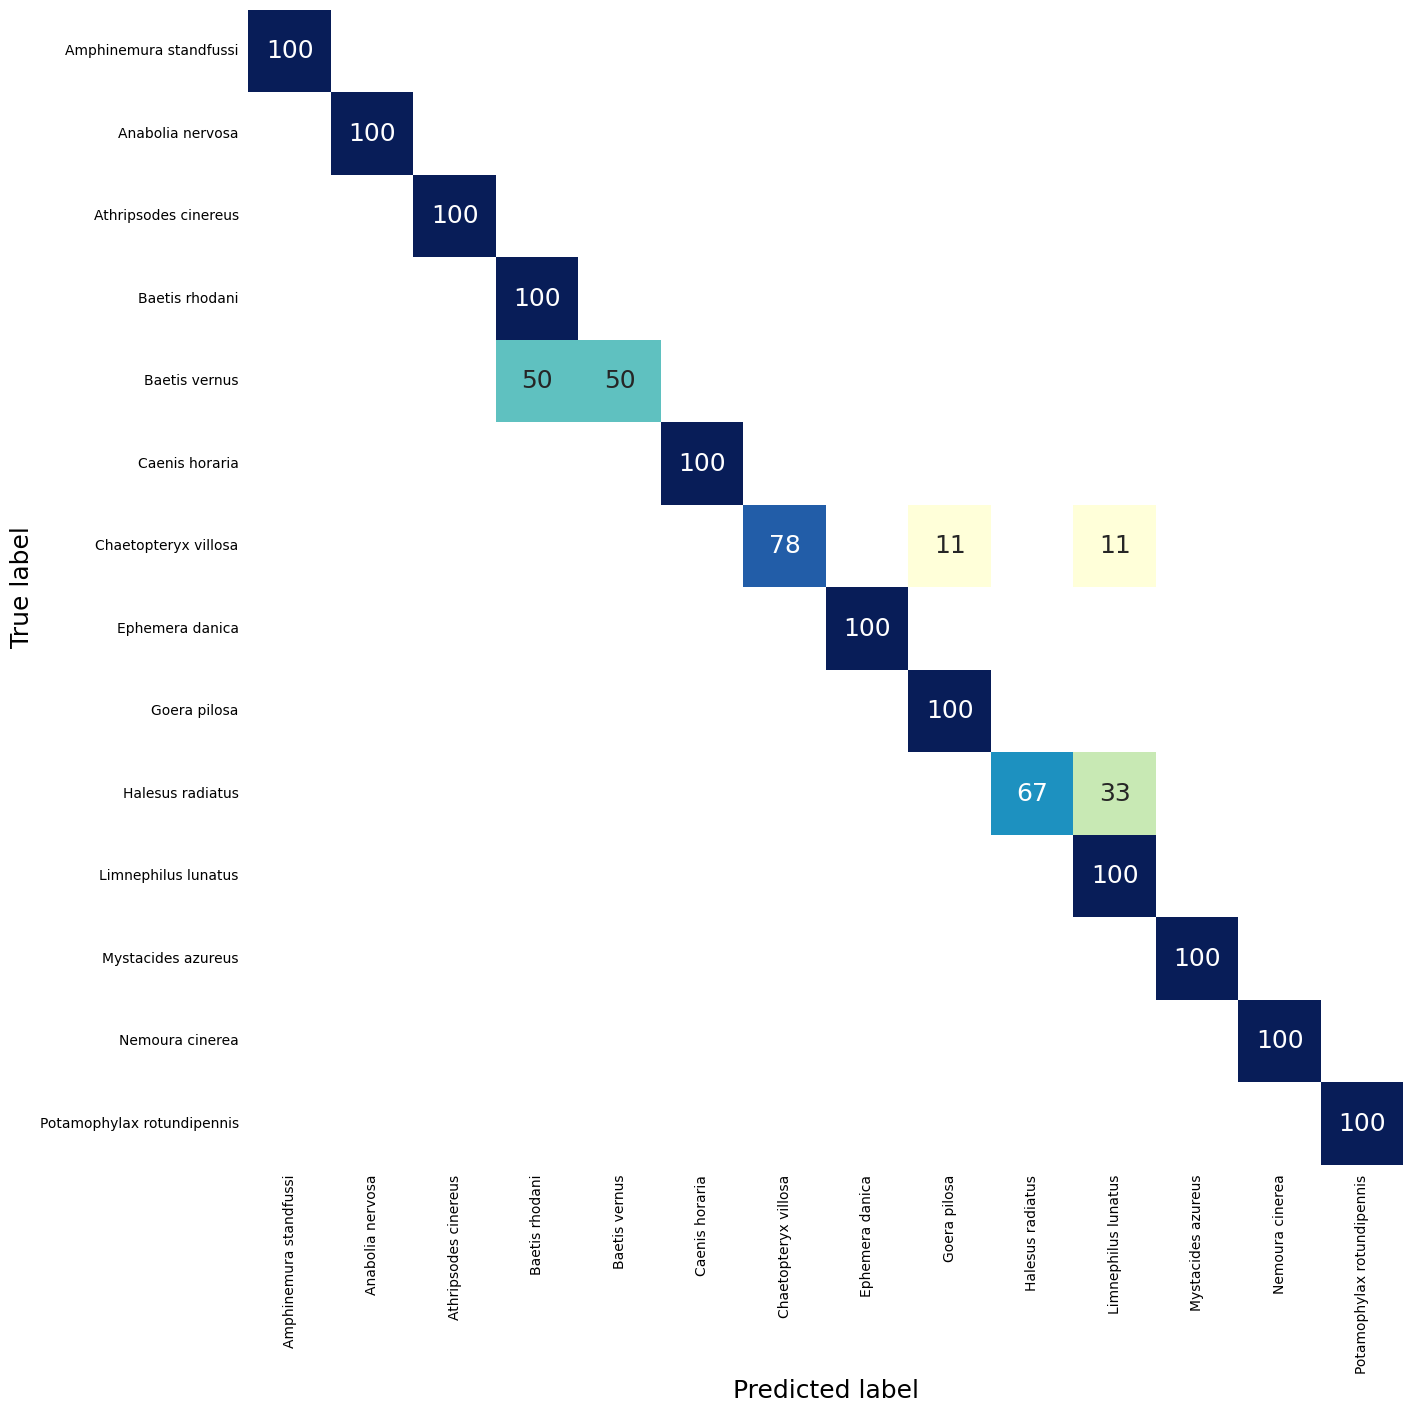

In [33]:
confusion_matrixX(results_df_grouped["Final_species_label"], results_df_grouped["y_pred"], classes='union')
plt.show()